In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime as dt
from scipy import stats
from scipy.stats import norm, skew

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn import metrics

import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingRegressor
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks,RandomUnderSampler,NearMiss

## Load Data

In [2]:
df_train = pd.read_csv("df_train.csv",encoding = "utf8") 
df_test = pd.read_csv("df_test.csv",encoding = "utf8") 

In [72]:
df_train=df_train[df_train.BROWSE_CNT>0]

In [73]:
df_train.NEXT_LN_APPLY.value_counts()

0.0    58267
1.0      392
Name: NEXT_LN_APPLY, dtype: int64

In [74]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58659 entries, 5 to 187678
Columns: 156 entries, CUST_NO to CUST_YEAR_WM_P
dtypes: float64(153), int64(1), object(2)
memory usage: 70.3+ MB


In [75]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 156 entries, CUST_NO to CUST_YEAR_WM_P
dtypes: float64(153), int64(1), object(2)
memory usage: 35.7+ MB


In [76]:
CM_CUST=['CUST_NO', 'CUST_YEAR', 'D90_TXN_CNT','IS_BROWSE', # 'CUST_START_DT',
       'BROWSE_CNT','BROWSE_URL',
       'BROWSE_DATE_LAST_DAYS','BROWSE_DATE_FIRST_DAYS',  
       'PAGE_OFTEN_CAT_3','PAGE_OFTEN_CAT_5','PAGE_OFTEN_CAT_9','PAGE_OFTEN_CAT_11','PAGE_OFTEN_CAT_14','PAGE_OFTEN_CAT_19',
       'PAGE_OFTEN_CAT_21','PAGE_OFTEN_CAT_23','PAGE_OFTEN_CAT_25','PAGE_OFTEN_CAT_35','PAGE_OFTEN_CAT_69',
       'PAGE_OFTEN_CAT_135','PAGE_OFTEN_CAT_155','PAGE_OFTEN_CAT_177','PAGE_OFTEN_CAT_192','PAGE_OFTEN_CAT_196',
       'PAGE_OFTEN_CAT_210','PAGE_OFTEN_CAT_223', 'PAGE_OFTEN_CAT_252','PAGE_OFTEN_CAT_257','PAGE_OFTEN_CAT_259',
       'PAGE_OFTEN_CAT_261','PAGE_OFTEN_CAT_999',
       'GENDER_CODE_F', 'GENDER_CODE_M','GENDER_CODE_999','AGE_1', 'AGE_2','AGE_3', 'AGE_4', 
       'CHILDREN_CNT_0.0', 'CHILDREN_CNT_1.0','CHILDREN_CNT_2.0', 'CHILDREN_CNT_3.0', 'CHILDREN_CNT_4.0',
       'CHILDREN_CNT_5.0', 'CHILDREN_CNT_6.0', 'CHILDREN_CNT_9.0','CHILDREN_CNT_10.0', 'CHILDREN_CNT_999.0',
       'EDU_CODE_1.0', 'EDU_CODE_2.0', 'EDU_CODE_3.0','EDU_CODE_4.0', 'EDU_CODE_5.0', 'EDU_CODE_6.0', 'EDU_CODE_999.0',
       'INCOME_RANGE_CODE_1.0','INCOME_RANGE_CODE_2.0', 'INCOME_RANGE_CODE_3.0','INCOME_RANGE_CODE_4.0', 'INCOME_RANGE_CODE_999.0',
       'WORK_MTHS_1.0', 'WORK_MTHS_2.0','WORK_MTHS_3.0', 'WORK_MTHS_4.0', 'WORK_MTHS_5.0','WORK_MTHS_999.0',
       'GENDER_LN','AGE_LN','CHILDREN_LN','EDU_CODE_LN','INCOME_RANGE_LN','WORK_MTHS_LN',
       'GENDER_CC','AGE_CC','CHILDREN_CC','EDU_CODE_CC','INCOME_RANGE_CC','WORK_MTHS_CC',
       'GENDER_FX','AGE_FX','CHILDREN_FX','EDU_CODE_FX','INCOME_RANGE_FX','WORK_MTHS_FX',
       'GENDER_WM','AGE_WM','CHILDREN_WM','EDU_CODE_WM','INCOME_RANGE_WM','WORK_MTHS_WM']

In [77]:
CM_LN = ['D0_LN_LAST_DAYS','D90_LN_CNT',  
         'LN_DAY_INTERVAL_LAST','LN_DAY_INTERVAL_FIRST','LN_DAY_INTERVAL_AVG', 
         'D90_LN_AMT_SUM','D90_LN_AMT_MIN','D90_LN_AMT_MAX','D90_LN_AMT_STD','D90_LN_AMT_AVG','LN_USE']

## Modeling

In [78]:
Y=df_train[['NEXT_LN_APPLY']].copy()

In [79]:
train=df_train[CM_CUST+CM_LN].copy()
test=df_test[CM_CUST+CM_LN].copy()

In [80]:
train['BROWSE_DATE_LAST_DAYS']=train['BROWSE_DATE_LAST_DAYS'].fillna(999)
train['BROWSE_DATE_FIRST_DAYS']=train['BROWSE_DATE_FIRST_DAYS'].fillna(999)
train['LN_DAY_INTERVAL_LAST']=train['LN_DAY_INTERVAL_LAST'].fillna(999)
train['LN_DAY_INTERVAL_FIRST']=train['LN_DAY_INTERVAL_FIRST'].fillna(999)
train['LN_DAY_INTERVAL_AVG']=train['LN_DAY_INTERVAL_AVG'].fillna(999)
train['BROWSE_DATE_LAST_DAYS']=train['BROWSE_DATE_LAST_DAYS'].fillna(999)
train['BROWSE_DATE_FIRST_DAYS']=train['BROWSE_DATE_FIRST_DAYS'].fillna(999)
train['LN_DAY_INTERVAL_FIRST']=train['LN_DAY_INTERVAL_FIRST'].fillna(999)
train['LN_DAY_INTERVAL_LAST']=train['LN_DAY_INTERVAL_LAST'].fillna(999)
train['LN_DAY_INTERVAL_AVG']=train['LN_DAY_INTERVAL_AVG'].fillna(999)

In [81]:
train=train.drop(['CUST_NO'], axis=1)
test=test.drop(['CUST_NO'], axis=1)

In [82]:
train=train.fillna(0)
test=test.fillna(0)

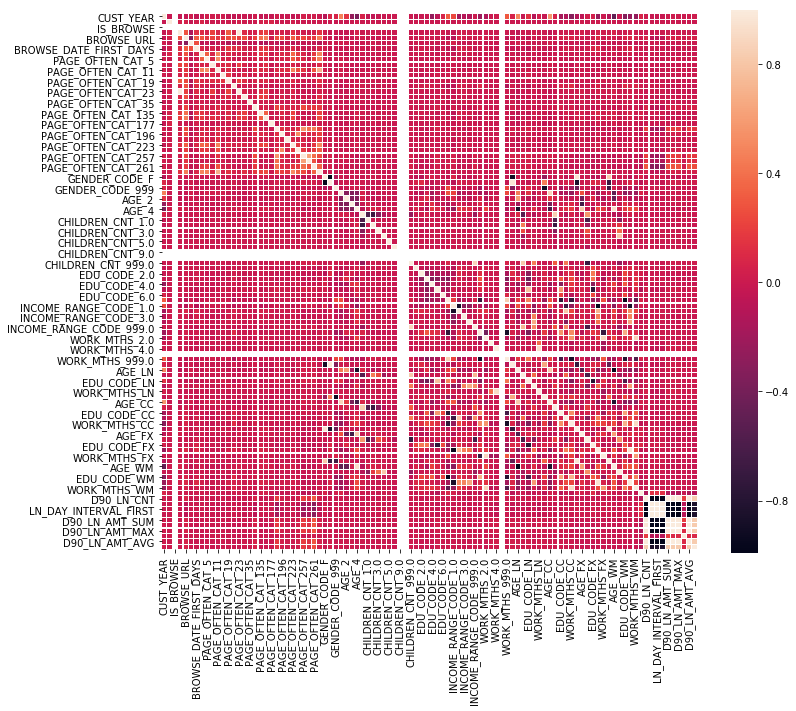

In [83]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, linewidths=0.1,vmax=1.0, square=True);

In [84]:
def correlation(col_corr, threshold):
    #col_corr = delcols#set() # Set of all the names of deleted columns
    corr_matrix = train.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.append(colname)
                if colname in train.columns:
                    del train[colname] # deleting the column from the dataset
                if colname in test.columns:
                    del test[colname] # deleting the column from the dataset

    print(col_corr)
    delcols=col_corr
    #print(dataset)

In [85]:
delcols=[]
correlation(delcols,0.95)

['PAGE_OFTEN_CAT_23', 'GENDER_LN', 'GENDER_WM', 'INCOME_RANGE_WM', 'LN_DAY_INTERVAL_FIRST', 'LN_DAY_INTERVAL_AVG', 'LN_DAY_INTERVAL_AVG', 'D90_LN_AMT_SUM', 'D90_LN_AMT_MIN', 'D90_LN_AMT_MIN', 'D90_LN_AMT_MAX', 'D90_LN_AMT_MAX', 'D90_LN_AMT_MAX', 'D90_LN_AMT_AVG', 'D90_LN_AMT_AVG', 'D90_LN_AMT_AVG', 'D90_LN_AMT_AVG']


In [86]:
delcols

['PAGE_OFTEN_CAT_23',
 'GENDER_LN',
 'GENDER_WM',
 'INCOME_RANGE_WM',
 'LN_DAY_INTERVAL_FIRST',
 'LN_DAY_INTERVAL_AVG',
 'LN_DAY_INTERVAL_AVG',
 'D90_LN_AMT_SUM',
 'D90_LN_AMT_MIN',
 'D90_LN_AMT_MIN',
 'D90_LN_AMT_MAX',
 'D90_LN_AMT_MAX',
 'D90_LN_AMT_MAX',
 'D90_LN_AMT_AVG',
 'D90_LN_AMT_AVG',
 'D90_LN_AMT_AVG',
 'D90_LN_AMT_AVG']

In [87]:
#'PAGE_OFTEN_CAT_23'
#train=train.drop(['GENDER_LN','GENDER_WM','INCOME_RANGE_WM','GENDER_LN', 'LN_DAY_INTERVAL_FIRST','LN_DAY_INTERVAL_AVG','D90_LN_AMT_SUM','D90_LN_AMT_MIN','D90_LN_AMT_MAX','D90_LN_AMT_AVG'], axis=1)
#test=test.drop(['GENDER_LN','GENDER_WM','INCOME_RANGE_WM','GENDER_LN', 'LN_DAY_INTERVAL_FIRST','LN_DAY_INTERVAL_AVG','D90_LN_AMT_SUM','D90_LN_AMT_MIN','D90_LN_AMT_MAX','D90_LN_AMT_AVG'], axis=1)

In [88]:
train.info(),test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58659 entries, 5 to 187678
Data columns (total 90 columns):
CUST_YEAR                  58659 non-null float64
D90_TXN_CNT                58659 non-null float64
IS_BROWSE                  58659 non-null int64
BROWSE_CNT                 58659 non-null float64
BROWSE_URL                 58659 non-null float64
BROWSE_DATE_LAST_DAYS      58659 non-null float64
BROWSE_DATE_FIRST_DAYS     58659 non-null float64
PAGE_OFTEN_CAT_3           58659 non-null float64
PAGE_OFTEN_CAT_5           58659 non-null float64
PAGE_OFTEN_CAT_9           58659 non-null float64
PAGE_OFTEN_CAT_11          58659 non-null float64
PAGE_OFTEN_CAT_14          58659 non-null float64
PAGE_OFTEN_CAT_19          58659 non-null float64
PAGE_OFTEN_CAT_21          58659 non-null float64
PAGE_OFTEN_CAT_25          58659 non-null float64
PAGE_OFTEN_CAT_35          58659 non-null float64
PAGE_OFTEN_CAT_69          58659 non-null float64
PAGE_OFTEN_CAT_135         58659 non-null 

(None, None)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(train,Y, test_size=0.3, random_state =42)

In [90]:
kf=KFold(n_splits=5, random_state=42, shuffle=True)

In [91]:
sc=StandardScaler()

In [92]:
X_train_std=sc.fit_transform(X_train)
X_test_std=sc.fit_transform(X_test)
test_std=sc.fit_transform(test)

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dty

In [93]:
lr= LogisticRegression(penalty='l1',C=1, random_state=42)

In [94]:
lr.fit(X_train_std, y_train)

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [95]:
print("R Square:",lr.score(X_test_std, y_test))
print("ROC AUC score:",metrics.roc_auc_score(y_test,lr.predict_proba(X_test_std)[:,1]))
print("F1 Square:",metrics.f1_score(y_test,lr.predict(X_test_std)))
print("recall:",metrics.recall_score(y_test,lr.predict(X_test_std)))
print("precision:",metrics.precision_score(y_test,lr.predict(X_test_std)))

R Square: 0.9921013751562677
ROC AUC score: 0.8033571559008582
F1 Square: 0.027972027972027972
recall: 0.014492753623188406
precision: 0.4


In [96]:
lgbc = lgb.LGBMClassifier(learning_rate=0.5,n_estimators=100,random_state=42,max_depth=4,scale_pos_weight=1)
#lgbc.fit(X_train, y_train,eval_metric='auc')
eval_set  = [(X_train , y_train) , (X_test , y_test)]
lgbc.fit(X_train ,  y_train ,eval_set=eval_set,eval_metric='auc',early_stopping_rounds=5)

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's auc: 0.831219	valid_1's auc: 0.798238
Training until validation scores don't improve for 5 rounds.
[2]	training's auc: 0.723561	valid_1's auc: 0.661472
[3]	training's auc: 0.731482	valid_1's auc: 0.661949
[4]	training's auc: 0.697493	valid_1's auc: 0.66823
[5]	training's auc: 0.700281	valid_1's auc: 0.672221
[6]	training's auc: 0.701901	valid_1's auc: 0.693774
Early stopping, best iteration is:
[1]	training's auc: 0.831219	valid_1's auc: 0.798238


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.5, max_depth=4, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=42,
        reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=1, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [97]:
print("R Square:",lgbc.score(X_test, y_test))
print("ROC AUC score:",metrics.roc_auc_score(y_test,lgbc.predict_proba(X_test)[:,1]))
print("F1 Square:",metrics.f1_score(y_test,lgbc.predict(X_test)))
print("recall:",metrics.recall_score(y_test,lgbc.predict(X_test)))
print("precision:",metrics.precision_score(y_test,lgbc.predict(X_test)))

R Square: 0.9824980111376292
ROC AUC score: 0.7982375865331938
F1 Square: 0.11494252873563218
recall: 0.14492753623188406
precision: 0.09523809523809523


In [98]:
params = {'learning_rate':[0.5],'n_estimators':[50,100,200],'scale_pos_weight':[1]}
gs_lgbc = GridSearchCV(estimator=lgbc, param_grid=params, cv=kf, verbose=1, scoring='f1') 
eval_set  = [(X_train , y_train) , (X_test , y_test)]
gs_lgbc.fit(X_train ,  y_train ,eval_set=eval_set,early_stopping_rounds=5,eval_metric='auc')#eval_metric='auc',

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vect

[1]	valid_0's auc: 0.819389	valid_1's auc: 0.768342
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.741069	valid_1's auc: 0.689185
[3]	valid_0's auc: 0.713108	valid_1's auc: 0.671339
[4]	valid_0's auc: 0.703338	valid_1's auc: 0.673641
[5]	valid_0's auc: 0.697516	valid_1's auc: 0.68597
[6]	valid_0's auc: 0.689005	valid_1's auc: 0.67646
Early stopping, best iteration is:
[1]	valid_0's auc: 0.819389	valid_1's auc: 0.768342


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.830368	valid_1's auc: 0.820328
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.785518	valid_1's auc: 0.743306
[3]	valid_0's auc: 0.780887	valid_1's auc: 0.698084
[4]	valid_0's auc: 0.761789	valid_1's auc: 0.683468
[5]	valid_0's auc: 0.757997	valid_1's auc: 0.671727
[6]	valid_0's auc: 0.777779	valid_1's auc: 0.681243
Early stopping, best iteration is:
[1]	valid_0's auc: 0.830368	valid_1's auc: 0.820328


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.828236	valid_1's auc: 0.793529
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.731394	valid_1's auc: 0.735514
[3]	valid_0's auc: 0.688707	valid_1's auc: 0.685257
[4]	valid_0's auc: 0.664595	valid_1's auc: 0.714733
[5]	valid_0's auc: 0.677892	valid_1's auc: 0.696157
[6]	valid_0's auc: 0.664605	valid_1's auc: 0.692707
Early stopping, best iteration is:
[1]	valid_0's auc: 0.828236	valid_1's auc: 0.793529


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.81215	valid_1's auc: 0.718736
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.753925	valid_1's auc: 0.677787
[3]	valid_0's auc: 0.764673	valid_1's auc: 0.67423
[4]	valid_0's auc: 0.75396	valid_1's auc: 0.667478
[5]	valid_0's auc: 0.760132	valid_1's auc: 0.682905
[6]	valid_0's auc: 0.775323	valid_1's auc: 0.685796
Early stopping, best iteration is:
[1]	valid_0's auc: 0.81215	valid_1's auc: 0.718736


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.829918	valid_1's auc: 0.797035
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.786708	valid_1's auc: 0.705237
[3]	valid_0's auc: 0.771282	valid_1's auc: 0.769672
[4]	valid_0's auc: 0.80737	valid_1's auc: 0.756656
[5]	valid_0's auc: 0.809248	valid_1's auc: 0.75843
[6]	valid_0's auc: 0.813486	valid_1's auc: 0.763421
Early stopping, best iteration is:
[1]	valid_0's auc: 0.829918	valid_1's auc: 0.797035


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.819389	valid_1's auc: 0.768342
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.741069	valid_1's auc: 0.689185
[3]	valid_0's auc: 0.713108	valid_1's auc: 0.671339
[4]	valid_0's auc: 0.703338	valid_1's auc: 0.673641
[5]	valid_0's auc: 0.697516	valid_1's auc: 0.68597
[6]	valid_0's auc: 0.689005	valid_1's auc: 0.67646
Early stopping, best iteration is:
[1]	valid_0's auc: 0.819389	valid_1's auc: 0.768342


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.830368	valid_1's auc: 0.820328
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.785518	valid_1's auc: 0.743306
[3]	valid_0's auc: 0.780887	valid_1's auc: 0.698084
[4]	valid_0's auc: 0.761789	valid_1's auc: 0.683468
[5]	valid_0's auc: 0.757997	valid_1's auc: 0.671727
[6]	valid_0's auc: 0.777779	valid_1's auc: 0.681243
Early stopping, best iteration is:
[1]	valid_0's auc: 0.830368	valid_1's auc: 0.820328


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.828236	valid_1's auc: 0.793529
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.731394	valid_1's auc: 0.735514
[3]	valid_0's auc: 0.688707	valid_1's auc: 0.685257
[4]	valid_0's auc: 0.664595	valid_1's auc: 0.714733
[5]	valid_0's auc: 0.677892	valid_1's auc: 0.696157
[6]	valid_0's auc: 0.664605	valid_1's auc: 0.692707
Early stopping, best iteration is:
[1]	valid_0's auc: 0.828236	valid_1's auc: 0.793529


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.81215	valid_1's auc: 0.718736
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.753925	valid_1's auc: 0.677787
[3]	valid_0's auc: 0.764673	valid_1's auc: 0.67423
[4]	valid_0's auc: 0.75396	valid_1's auc: 0.667478
[5]	valid_0's auc: 0.760132	valid_1's auc: 0.682905
[6]	valid_0's auc: 0.775323	valid_1's auc: 0.685796
Early stopping, best iteration is:
[1]	valid_0's auc: 0.81215	valid_1's auc: 0.718736


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.829918	valid_1's auc: 0.797035
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.786708	valid_1's auc: 0.705237
[3]	valid_0's auc: 0.771282	valid_1's auc: 0.769672
[4]	valid_0's auc: 0.80737	valid_1's auc: 0.756656
[5]	valid_0's auc: 0.809248	valid_1's auc: 0.75843
[6]	valid_0's auc: 0.813486	valid_1's auc: 0.763421
Early stopping, best iteration is:
[1]	valid_0's auc: 0.829918	valid_1's auc: 0.797035


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.819389	valid_1's auc: 0.768342
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.741069	valid_1's auc: 0.689185
[3]	valid_0's auc: 0.713108	valid_1's auc: 0.671339
[4]	valid_0's auc: 0.703338	valid_1's auc: 0.673641
[5]	valid_0's auc: 0.697516	valid_1's auc: 0.68597
[6]	valid_0's auc: 0.689005	valid_1's auc: 0.67646
Early stopping, best iteration is:
[1]	valid_0's auc: 0.819389	valid_1's auc: 0.768342


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.830368	valid_1's auc: 0.820328
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.785518	valid_1's auc: 0.743306
[3]	valid_0's auc: 0.780887	valid_1's auc: 0.698084
[4]	valid_0's auc: 0.761789	valid_1's auc: 0.683468
[5]	valid_0's auc: 0.757997	valid_1's auc: 0.671727
[6]	valid_0's auc: 0.777779	valid_1's auc: 0.681243
Early stopping, best iteration is:
[1]	valid_0's auc: 0.830368	valid_1's auc: 0.820328


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.828236	valid_1's auc: 0.793529
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.731394	valid_1's auc: 0.735514
[3]	valid_0's auc: 0.688707	valid_1's auc: 0.685257
[4]	valid_0's auc: 0.664595	valid_1's auc: 0.714733
[5]	valid_0's auc: 0.677892	valid_1's auc: 0.696157
[6]	valid_0's auc: 0.664605	valid_1's auc: 0.692707
Early stopping, best iteration is:
[1]	valid_0's auc: 0.828236	valid_1's auc: 0.793529


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.81215	valid_1's auc: 0.718736
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.753925	valid_1's auc: 0.677787
[3]	valid_0's auc: 0.764673	valid_1's auc: 0.67423
[4]	valid_0's auc: 0.75396	valid_1's auc: 0.667478
[5]	valid_0's auc: 0.760132	valid_1's auc: 0.682905
[6]	valid_0's auc: 0.775323	valid_1's auc: 0.685796
Early stopping, best iteration is:
[1]	valid_0's auc: 0.81215	valid_1's auc: 0.718736


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.829918	valid_1's auc: 0.797035
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.786708	valid_1's auc: 0.705237
[3]	valid_0's auc: 0.771282	valid_1's auc: 0.769672
[4]	valid_0's auc: 0.80737	valid_1's auc: 0.756656
[5]	valid_0's auc: 0.809248	valid_1's auc: 0.75843
[6]	valid_0's auc: 0.813486	valid_1's auc: 0.763421
Early stopping, best iteration is:
[1]	valid_0's auc: 0.829918	valid_1's auc: 0.797035


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    9.1s finished
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's auc: 0.831219	valid_1's auc: 0.798238
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.723561	valid_1's auc: 0.661472
[3]	valid_0's auc: 0.731482	valid_1's auc: 0.661949
[4]	valid_0's auc: 0.697493	valid_1's auc: 0.66823
[5]	valid_0's auc: 0.700281	valid_1's auc: 0.672221
[6]	valid_0's auc: 0.701901	valid_1's auc: 0.693774
Early stopping, best iteration is:
[1]	valid_0's auc: 0.831219	valid_1's auc: 0.798238


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.5, max_depth=4, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=42,
        reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=1, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.5], 'n_estimators': [50, 100, 200], 'scale_pos_weight': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [99]:
gs_lgbc.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.5, max_depth=4, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
        n_jobs=-1, num_leaves=31, objective=None, random_state=42,
        reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=1, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [100]:
print("R Square:",metrics.accuracy_score(y_test, gs_lgbc.best_estimator_.predict(X_test)))
print("ROC AUC score:",metrics.roc_auc_score(y_test,gs_lgbc.best_estimator_.predict_proba(X_test)[:,1]))
print("F1 Square:",metrics.f1_score(y_test,gs_lgbc.best_estimator_.predict(X_test)))
print("recall:",metrics.recall_score(y_test,gs_lgbc.best_estimator_.predict(X_test)))
print("precision:",metrics.precision_score(y_test,gs_lgbc.best_estimator_.predict(X_test)))

R Square: 0.9824980111376292
ROC AUC score: 0.7982375865331938
F1 Square: 0.11494252873563218
recall: 0.14492753623188406
precision: 0.09523809523809523


In [101]:
xgbc = xgb.XGBClassifier(learning_rate=1, n_estimators=100,random_state=42,max_depth=3,scale_pos_weight=1,tree_method='gpu_hist')
#xgbc.fit(X_train,y_train, eval_metric=5auc')
eval_set  = [(X_train , y_train) , (X_test , y_test)]
xgbc.fit(X_train ,  y_train ,eval_set=eval_set,eval_metric='auc',early_stopping_rounds=5)

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[0]	validation_0-auc:0.7619	validation_1-auc:0.777743
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.822196	validation_1-auc:0.819992
[2]	validation_0-auc:0.836352	validation_1-auc:0.825055
[3]	validation_0-auc:0.83743	validation_1-auc:0.820849
[4]	validation_0-auc:0.84386	validation_1-auc:0.827762
[5]	validation_0-auc:0.884734	validation_1-auc:0.846476
[6]	validation_0-auc:0.893429	validation_1-auc:0.84748
[7]	validation_0-auc:0.905409	validation_1-auc:0.845627
[8]	validation_0-auc:0.905347	validation_1-auc:0.847864
[9]	validation_0-auc:0.905969	validation_1-auc:0.848173
[10]	validation_0-auc:0.908442	validation_1-auc:0.853047
[11]	validation_0-auc:0.914683	validation_1-auc:0.847215
[12]	validation_0-auc:0.91832	validation_1-auc:0.839287
[13]	validation_0-auc:0.919299	validation_1-auc:0.840333
[14]	validation_0-auc:0.920822	validation_1-auc:0.835884
[15]	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, tree_method='gpu_hist')

In [102]:
print("R Square:",metrics.accuracy_score(y_test, xgbc.predict(X_test)))
print("ROC AUC score:",metrics.roc_auc_score(y_test,xgbc.predict_proba(X_test)[:,1]))
print("F1 Square:",metrics.f1_score(y_test,xgbc.predict(X_test)))
print("recall:",metrics.recall_score(y_test,xgbc.predict(X_test)))
print("precision:",metrics.precision_score(y_test,xgbc.predict(X_test)))

R Square: 0.9920445505171042
ROC AUC score: 0.853047130501187
F1 Square: 0.06666666666666667
recall: 0.036231884057971016
precision: 0.4166666666666667


In [103]:
params = {'learning_rate':[0.5,1],'n_estimators':[50,100],'scale_pos_weight':[1]}
gs_xgbc = GridSearchCV(estimator=xgbc, param_grid=params, cv=kf,verbose=1, scoring='f1') 
#gs_xgbc.fit(X_train, y_train)
eval_set  = [(X_train , y_train) , (X_test , y_test)]
gs_xgbc.fit(X_train ,  y_train ,eval_set=eval_set,early_stopping_rounds=5,eval_metric='auc')#eval_metric='auc',

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vect

[0]	validation_0-auc:0.76722	validation_1-auc:0.777123
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.818115	validation_1-auc:0.820758
[2]	validation_0-auc:0.83401	validation_1-auc:0.826276
[3]	validation_0-auc:0.835079	validation_1-auc:0.826825
[4]	validation_0-auc:0.836087	validation_1-auc:0.826355
[5]	validation_0-auc:0.834359	validation_1-auc:0.824777
[6]	validation_0-auc:0.840223	validation_1-auc:0.827992
[7]	validation_0-auc:0.841657	validation_1-auc:0.827173
[8]	validation_0-auc:0.839791	validation_1-auc:0.824753
[9]	validation_0-auc:0.841606	validation_1-auc:0.825101
[10]	validation_0-auc:0.871438	validation_1-auc:0.819688
[11]	validation_0-auc:0.866962	validation_1-auc:0.82134
Stopping. Best iteration:
[6]	validation_0-auc:0.840223	validation_1-auc:0.827992



C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  

[0]	validation_0-auc:0.76599	validation_1-auc:0.781485
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.819741	validation_1-auc:0.821229
[2]	validation_0-auc:0.82937	validation_1-auc:0.826639
[3]	validation_0-auc:0.83246	validation_1-auc:0.82724
[4]	validation_0-auc:0.830007	validation_1-auc:0.826071
[5]	validation_0-auc:0.831966	validation_1-auc:0.825977
[6]	validation_0-auc:0.833863	validation_1-auc:0.821226
[7]	validation_0-auc:0.83862	validation_1-auc:0.821447
[8]	validation_0-auc:0.83999	validation_1-auc:0.822948
Stopping. Best iteration:
[3]	validation_0-auc:0.83246	validation_1-auc:0.82724



C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  

[0]	validation_0-auc:0.760708	validation_1-auc:0.777853
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.818352	validation_1-auc:0.82109
[2]	validation_0-auc:0.821354	validation_1-auc:0.820798
[3]	validation_0-auc:0.832355	validation_1-auc:0.824111
[4]	validation_0-auc:0.832792	validation_1-auc:0.824167
[5]	validation_0-auc:0.837724	validation_1-auc:0.828274
[6]	validation_0-auc:0.840744	validation_1-auc:0.831845
[7]	validation_0-auc:0.84168	validation_1-auc:0.830407
[8]	validation_0-auc:0.842636	validation_1-auc:0.830022
[9]	validation_0-auc:0.846925	validation_1-auc:0.831121
[10]	validation_0-auc:0.879275	validation_1-auc:0.843198
[11]	validation_0-auc:0.897727	validation_1-auc:0.838504
[12]	validation_0-auc:0.906236	validation_1-auc:0.841889
[13]	validation_0-auc:0.911165	validation_1-auc:0.842811
[14]	validation_0-auc:0.911823	validation_1-auc:0.842692
[

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  

[0]	validation_0-auc:0.753975	validation_1-auc:0.773955
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.816445	validation_1-auc:0.820228
[2]	validation_0-auc:0.820056	validation_1-auc:0.820388
[3]	validation_0-auc:0.819755	validation_1-auc:0.818685
[4]	validation_0-auc:0.820573	validation_1-auc:0.815863
[5]	validation_0-auc:0.833107	validation_1-auc:0.819847
[6]	validation_0-auc:0.838849	validation_1-auc:0.821893
[7]	validation_0-auc:0.839508	validation_1-auc:0.823449
[8]	validation_0-auc:0.84049	validation_1-auc:0.82265
[9]	validation_0-auc:0.845156	validation_1-auc:0.826331
[10]	validation_0-auc:0.874676	validation_1-auc:0.837217
[11]	validation_0-auc:0.889519	validation_1-auc:0.839803
[12]	validation_0-auc:0.9028	validation_1-auc:0.846603
[13]	validation_0-auc:0.907731	validation_1-auc:0.846174
[14]	validation_0-auc:0.911642	validation_1-auc:0.850155
[15

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[0]	validation_0-auc:0.766381	validation_1-auc:0.781369
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.822255	validation_1-auc:0.823985
[2]	validation_0-auc:0.826401	validation_1-auc:0.824156
[3]	validation_0-auc:0.825854	validation_1-auc:0.824278
[4]	validation_0-auc:0.825071	validation_1-auc:0.819692
[5]	validation_0-auc:0.833165	validation_1-auc:0.822273
[6]	validation_0-auc:0.834091	validation_1-auc:0.82431
[7]	validation_0-auc:0.83459	validation_1-auc:0.823699
[8]	validation_0-auc:0.834825	validation_1-auc:0.823198
[9]	validation_0-auc:0.841172	validation_1-auc:0.826982
[10]	validation_0-auc:0.867652	validation_1-auc:0.832137
[11]	validation_0-auc:0.887099	validation_1-auc:0.834182
[12]	validation_0-auc:0.893927	validation_1-auc:0.838469
[13]	validation_0-auc:0.897635	validation_1-auc:0.834167
[14]	validation_0-auc:0.901374	validation_1-auc:0.835482
[

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  

[0]	validation_0-auc:0.76722	validation_1-auc:0.777123
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.818115	validation_1-auc:0.820758
[2]	validation_0-auc:0.83401	validation_1-auc:0.826276
[3]	validation_0-auc:0.835079	validation_1-auc:0.826825
[4]	validation_0-auc:0.836087	validation_1-auc:0.826355
[5]	validation_0-auc:0.834359	validation_1-auc:0.824777
[6]	validation_0-auc:0.840223	validation_1-auc:0.827992
[7]	validation_0-auc:0.841657	validation_1-auc:0.827173
[8]	validation_0-auc:0.839791	validation_1-auc:0.824753
[9]	validation_0-auc:0.841606	validation_1-auc:0.825101
[10]	validation_0-auc:0.871438	validation_1-auc:0.819688
[11]	validation_0-auc:0.866962	validation_1-auc:0.82134
Stopping. Best iteration:
[6]	validation_0-auc:0.840223	validation_1-auc:0.827992



C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  

[0]	validation_0-auc:0.76599	validation_1-auc:0.781485
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.819741	validation_1-auc:0.821229
[2]	validation_0-auc:0.82937	validation_1-auc:0.826639
[3]	validation_0-auc:0.83246	validation_1-auc:0.82724
[4]	validation_0-auc:0.830007	validation_1-auc:0.826071
[5]	validation_0-auc:0.831966	validation_1-auc:0.825977
[6]	validation_0-auc:0.833863	validation_1-auc:0.821226
[7]	validation_0-auc:0.83862	validation_1-auc:0.821447
[8]	validation_0-auc:0.83999	validation_1-auc:0.822948
Stopping. Best iteration:
[3]	validation_0-auc:0.83246	validation_1-auc:0.82724



C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  

[0]	validation_0-auc:0.760708	validation_1-auc:0.777853
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.818352	validation_1-auc:0.82109
[2]	validation_0-auc:0.821354	validation_1-auc:0.820798
[3]	validation_0-auc:0.832355	validation_1-auc:0.824111
[4]	validation_0-auc:0.832792	validation_1-auc:0.824167
[5]	validation_0-auc:0.837724	validation_1-auc:0.828274
[6]	validation_0-auc:0.840744	validation_1-auc:0.831845
[7]	validation_0-auc:0.84168	validation_1-auc:0.830407
[8]	validation_0-auc:0.842636	validation_1-auc:0.830022
[9]	validation_0-auc:0.846925	validation_1-auc:0.831121
[10]	validation_0-auc:0.879275	validation_1-auc:0.843198
[11]	validation_0-auc:0.897727	validation_1-auc:0.838504
[12]	validation_0-auc:0.906236	validation_1-auc:0.841889
[13]	validation_0-auc:0.911165	validation_1-auc:0.842811
[14]	validation_0-auc:0.911823	validation_1-auc:0.842692
[

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  

[0]	validation_0-auc:0.753975	validation_1-auc:0.773955
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.816445	validation_1-auc:0.820228
[2]	validation_0-auc:0.820056	validation_1-auc:0.820388
[3]	validation_0-auc:0.819755	validation_1-auc:0.818685
[4]	validation_0-auc:0.820573	validation_1-auc:0.815863
[5]	validation_0-auc:0.833107	validation_1-auc:0.819847
[6]	validation_0-auc:0.838849	validation_1-auc:0.821893
[7]	validation_0-auc:0.839508	validation_1-auc:0.823449
[8]	validation_0-auc:0.84049	validation_1-auc:0.82265
[9]	validation_0-auc:0.845156	validation_1-auc:0.826331
[10]	validation_0-auc:0.874676	validation_1-auc:0.837217
[11]	validation_0-auc:0.889519	validation_1-auc:0.839803
[12]	validation_0-auc:0.9028	validation_1-auc:0.846603
[13]	validation_0-auc:0.907731	validation_1-auc:0.846174
[14]	validation_0-auc:0.911642	validation_1-auc:0.850155
[15

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[0]	validation_0-auc:0.766381	validation_1-auc:0.781369
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.822255	validation_1-auc:0.823985
[2]	validation_0-auc:0.826401	validation_1-auc:0.824156
[3]	validation_0-auc:0.825854	validation_1-auc:0.824278
[4]	validation_0-auc:0.825071	validation_1-auc:0.819692
[5]	validation_0-auc:0.833165	validation_1-auc:0.822273
[6]	validation_0-auc:0.834091	validation_1-auc:0.82431
[7]	validation_0-auc:0.83459	validation_1-auc:0.823699
[8]	validation_0-auc:0.834825	validation_1-auc:0.823198
[9]	validation_0-auc:0.841172	validation_1-auc:0.826982
[10]	validation_0-auc:0.867652	validation_1-auc:0.832137
[11]	validation_0-auc:0.887099	validation_1-auc:0.834182
[12]	validation_0-auc:0.893927	validation_1-auc:0.838469
[13]	validation_0-auc:0.897635	validation_1-auc:0.834167
[14]	validation_0-auc:0.901374	validation_1-auc:0.835482
[

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  

[0]	validation_0-auc:0.76722	validation_1-auc:0.777123
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.82319	validation_1-auc:0.823977
[2]	validation_0-auc:0.830523	validation_1-auc:0.823829
[3]	validation_0-auc:0.834516	validation_1-auc:0.823472
[4]	validation_0-auc:0.852105	validation_1-auc:0.831923
[5]	validation_0-auc:0.887319	validation_1-auc:0.838228
[6]	validation_0-auc:0.894105	validation_1-auc:0.833156
[7]	validation_0-auc:0.897541	validation_1-auc:0.831028
[8]	validation_0-auc:0.895726	validation_1-auc:0.831748
[9]	validation_0-auc:0.902226	validation_1-auc:0.829162
[10]	validation_0-auc:0.900769	validation_1-auc:0.825882
Stopping. Best iteration:
[5]	validation_0-auc:0.887319	validation_1-auc:0.838228



C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[0]	validation_0-auc:0.76599	validation_1-auc:0.781485
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.827329	validation_1-auc:0.82427
[2]	validation_0-auc:0.830024	validation_1-auc:0.823164
[3]	validation_0-auc:0.835407	validation_1-auc:0.824065
[4]	validation_0-auc:0.839994	validation_1-auc:0.826917
[5]	validation_0-auc:0.874868	validation_1-auc:0.848032
[6]	validation_0-auc:0.885475	validation_1-auc:0.845874
[7]	validation_0-auc:0.893345	validation_1-auc:0.845809
[8]	validation_0-auc:0.902344	validation_1-auc:0.84128
[9]	validation_0-auc:0.905753	validation_1-auc:0.832319
[10]	validation_0-auc:0.908205	validation_1-auc:0.829366
Stopping. Best iteration:
[5]	validation_0-auc:0.874868	validation_1-auc:0.848032



C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[0]	validation_0-auc:0.760708	validation_1-auc:0.777853
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.832332	validation_1-auc:0.827677
[2]	validation_0-auc:0.832171	validation_1-auc:0.825686
[3]	validation_0-auc:0.835341	validation_1-auc:0.824991
[4]	validation_0-auc:0.843254	validation_1-auc:0.827227
[5]	validation_0-auc:0.885107	validation_1-auc:0.838295
[6]	validation_0-auc:0.898865	validation_1-auc:0.849554
[7]	validation_0-auc:0.902382	validation_1-auc:0.8366
[8]	validation_0-auc:0.907104	validation_1-auc:0.834544
[9]	validation_0-auc:0.908098	validation_1-auc:0.833225
[10]	validation_0-auc:0.910127	validation_1-auc:0.835887
[11]	validation_0-auc:0.911203	validation_1-auc:0.833353
Stopping. Best iteration:
[6]	validation_0-auc:0.898865	validation_1-auc:0.849554



C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[0]	validation_0-auc:0.753975	validation_1-auc:0.773955
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.827592	validation_1-auc:0.823947
[2]	validation_0-auc:0.831698	validation_1-auc:0.82121
[3]	validation_0-auc:0.837428	validation_1-auc:0.818939
[4]	validation_0-auc:0.84349	validation_1-auc:0.82199
[5]	validation_0-auc:0.881281	validation_1-auc:0.83489
[6]	validation_0-auc:0.889201	validation_1-auc:0.8338
[7]	validation_0-auc:0.895085	validation_1-auc:0.836726
[8]	validation_0-auc:0.89703	validation_1-auc:0.831846
[9]	validation_0-auc:0.901766	validation_1-auc:0.830894
[10]	validation_0-auc:0.902222	validation_1-auc:0.823667
[11]	validation_0-auc:0.904763	validation_1-auc:0.821344
[12]	validation_0-auc:0.906542	validation_1-auc:0.815625
Stopping. Best iteration:
[7]	validation_0-auc:0.895085	validation_1-auc:0.836726



C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[0]	validation_0-auc:0.766381	validation_1-auc:0.781369
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.830372	validation_1-auc:0.824328
[2]	validation_0-auc:0.83244	validation_1-auc:0.822258
[3]	validation_0-auc:0.832633	validation_1-auc:0.82201
[4]	validation_0-auc:0.839796	validation_1-auc:0.823245
[5]	validation_0-auc:0.870732	validation_1-auc:0.831472
[6]	validation_0-auc:0.880953	validation_1-auc:0.838647
[7]	validation_0-auc:0.884819	validation_1-auc:0.844969
[8]	validation_0-auc:0.888271	validation_1-auc:0.834018
[9]	validation_0-auc:0.888589	validation_1-auc:0.845334
[10]	validation_0-auc:0.89713	validation_1-auc:0.843231
[11]	validation_0-auc:0.902508	validation_1-auc:0.838775
[12]	validation_0-auc:0.903407	validation_1-auc:0.84523
[13]	validation_0-auc:0.907198	validation_1-auc:0.831613
[14]	validation_0-auc:0.908445	validation_1-auc:0.828098
Sto

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[0]	validation_0-auc:0.76722	validation_1-auc:0.777123
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.82319	validation_1-auc:0.823977
[2]	validation_0-auc:0.830523	validation_1-auc:0.823829
[3]	validation_0-auc:0.834516	validation_1-auc:0.823472
[4]	validation_0-auc:0.852105	validation_1-auc:0.831923
[5]	validation_0-auc:0.887319	validation_1-auc:0.838228
[6]	validation_0-auc:0.894105	validation_1-auc:0.833156
[7]	validation_0-auc:0.897541	validation_1-auc:0.831028
[8]	validation_0-auc:0.895726	validation_1-auc:0.831748
[9]	validation_0-auc:0.902226	validation_1-auc:0.829162
[10]	validation_0-auc:0.900769	validation_1-auc:0.825882
Stopping. Best iteration:
[5]	validation_0-auc:0.887319	validation_1-auc:0.838228



C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[0]	validation_0-auc:0.76599	validation_1-auc:0.781485
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.827329	validation_1-auc:0.82427
[2]	validation_0-auc:0.830024	validation_1-auc:0.823164
[3]	validation_0-auc:0.835407	validation_1-auc:0.824065
[4]	validation_0-auc:0.839994	validation_1-auc:0.826917
[5]	validation_0-auc:0.874868	validation_1-auc:0.848032
[6]	validation_0-auc:0.885475	validation_1-auc:0.845874
[7]	validation_0-auc:0.893345	validation_1-auc:0.845809
[8]	validation_0-auc:0.902344	validation_1-auc:0.84128
[9]	validation_0-auc:0.905753	validation_1-auc:0.832319
[10]	validation_0-auc:0.908205	validation_1-auc:0.829366
Stopping. Best iteration:
[5]	validation_0-auc:0.874868	validation_1-auc:0.848032



C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[0]	validation_0-auc:0.760708	validation_1-auc:0.777853
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.832332	validation_1-auc:0.827677
[2]	validation_0-auc:0.832171	validation_1-auc:0.825686
[3]	validation_0-auc:0.835341	validation_1-auc:0.824991
[4]	validation_0-auc:0.843254	validation_1-auc:0.827227
[5]	validation_0-auc:0.885107	validation_1-auc:0.838295
[6]	validation_0-auc:0.898865	validation_1-auc:0.849554
[7]	validation_0-auc:0.902382	validation_1-auc:0.8366
[8]	validation_0-auc:0.907104	validation_1-auc:0.834544
[9]	validation_0-auc:0.908098	validation_1-auc:0.833225
[10]	validation_0-auc:0.910127	validation_1-auc:0.835887
[11]	validation_0-auc:0.911203	validation_1-auc:0.833353
Stopping. Best iteration:
[6]	validation_0-auc:0.898865	validation_1-auc:0.849554



C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[0]	validation_0-auc:0.753975	validation_1-auc:0.773955
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.827592	validation_1-auc:0.823947
[2]	validation_0-auc:0.831698	validation_1-auc:0.82121
[3]	validation_0-auc:0.837428	validation_1-auc:0.818939
[4]	validation_0-auc:0.84349	validation_1-auc:0.82199
[5]	validation_0-auc:0.881281	validation_1-auc:0.83489
[6]	validation_0-auc:0.889201	validation_1-auc:0.8338
[7]	validation_0-auc:0.895085	validation_1-auc:0.836726
[8]	validation_0-auc:0.89703	validation_1-auc:0.831846
[9]	validation_0-auc:0.901766	validation_1-auc:0.830894
[10]	validation_0-auc:0.902222	validation_1-auc:0.823667
[11]	validation_0-auc:0.904763	validation_1-auc:0.821344
[12]	validation_0-auc:0.906542	validation_1-auc:0.815625
Stopping. Best iteration:
[7]	validation_0-auc:0.895085	validation_1-auc:0.836726



C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[0]	validation_0-auc:0.766381	validation_1-auc:0.781369
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.830372	validation_1-auc:0.824328
[2]	validation_0-auc:0.83244	validation_1-auc:0.822258
[3]	validation_0-auc:0.832633	validation_1-auc:0.82201
[4]	validation_0-auc:0.839796	validation_1-auc:0.823245
[5]	validation_0-auc:0.870732	validation_1-auc:0.831472
[6]	validation_0-auc:0.880953	validation_1-auc:0.838647
[7]	validation_0-auc:0.884819	validation_1-auc:0.844969
[8]	validation_0-auc:0.888271	validation_1-auc:0.834018
[9]	validation_0-auc:0.888589	validation_1-auc:0.845334
[10]	validation_0-auc:0.89713	validation_1-auc:0.843231
[11]	validation_0-auc:0.902508	validation_1-auc:0.838775
[12]	validation_0-auc:0.903407	validation_1-auc:0.84523
[13]	validation_0-auc:0.907198	validation_1-auc:0.831613
[14]	validation_0-auc:0.908445	validation_1-auc:0.828098
Sto

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   12.0s finished
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was pa

[0]	validation_0-auc:0.7619	validation_1-auc:0.777743
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.822196	validation_1-auc:0.819992
[2]	validation_0-auc:0.836352	validation_1-auc:0.825055
[3]	validation_0-auc:0.83743	validation_1-auc:0.820849
[4]	validation_0-auc:0.84386	validation_1-auc:0.827762
[5]	validation_0-auc:0.884734	validation_1-auc:0.846476
[6]	validation_0-auc:0.893429	validation_1-auc:0.84748
[7]	validation_0-auc:0.905409	validation_1-auc:0.845627
[8]	validation_0-auc:0.905347	validation_1-auc:0.847864
[9]	validation_0-auc:0.905969	validation_1-auc:0.848173
[10]	validation_0-auc:0.908442	validation_1-auc:0.853047
[11]	validation_0-auc:0.914683	validation_1-auc:0.847215
[12]	validation_0-auc:0.91832	validation_1-auc:0.839287
[13]	validation_0-auc:0.919299	validation_1-auc:0.840333
[14]	validation_0-auc:0.920822	validation_1-auc:0.835884
[15]	

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, tree_method='gpu_hist'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.5, 1], 'n_estimators': [50, 100], 'scale_pos_weight': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [104]:
gs_xgbc.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, tree_method='gpu_hist')

In [105]:
print("R Square:",metrics.accuracy_score(y_test, gs_xgbc.best_estimator_.predict(X_test)))
print("ROC AUC score:",metrics.roc_auc_score(y_test,gs_xgbc.best_estimator_.predict_proba(X_test)[:,1]))
print("F1 Square:",metrics.f1_score(y_test,gs_xgbc.best_estimator_.predict(X_test)))
print("recall:",metrics.recall_score(y_test,gs_xgbc.best_estimator_.predict(X_test)))
print("precision:",metrics.precision_score(y_test,gs_xgbc.best_estimator_.predict(X_test)))

R Square: 0.9920445505171042
ROC AUC score: 0.853047130501187
F1 Square: 0.06666666666666667
recall: 0.036231884057971016
precision: 0.4166666666666667


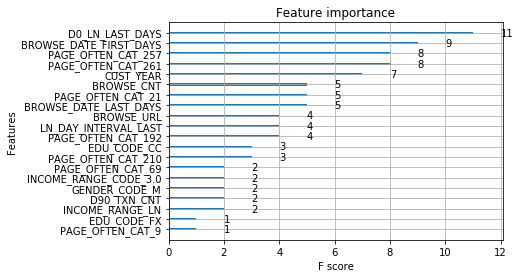

In [106]:
from xgboost import plot_importance
plot_importance(xgbc,max_num_features=20)
plt.show()

In [107]:
clf = RandomForestClassifier(n_estimators=100,random_state=42)
params = {'n_estimators':[100]} #{'class_weight':[{0:1, 1:pos_weight} for pos_weight in np.arange(1,3,2)]}
gs_rfx = GridSearchCV(estimator=clf, param_grid=params, cv=kf, scoring='f1')
gs_rfx.fit(X_train ,  y_train)

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='f1', verbose=0)

In [108]:
gs_rfx.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [109]:
print("R Square:",metrics.accuracy_score(y_test, gs_rfx.best_estimator_.predict(X_test)))
print("ROC AUC score:",metrics.roc_auc_score(y_test,gs_rfx.best_estimator_.predict_proba(X_test)[:,1]))
print("F1 Square:",metrics.f1_score(y_test,gs_rfx.best_estimator_.predict(X_test)))
print("recall:",metrics.recall_score(y_test,gs_rfx.best_estimator_.predict(X_test)))
print("precision:",metrics.precision_score(y_test,gs_rfx.best_estimator_.predict(X_test)))

R Square: 0.9923286737129219
ROC AUC score: 0.7834941564154921
F1 Square: 0.042553191489361694
recall: 0.021739130434782608
precision: 1.0


In [110]:
from vecstack import stacking

In [111]:
X_train, X_test, y_train, y_test = train_test_split(train, Y, test_size=0.2, random_state=42)

In [112]:
# Initialize 1st level estimators
models = [gs_xgbc.best_estimator_,gs_lgbc.best_estimator_,gs_rfx.best_estimator_,lr]

S_X_train, S_X_test = stacking(models, X_train, y_train, X_test, 
    regression = False, metric = metrics.log_loss, n_folds = 4,needs_proba=True,
    stratified = True, shuffle = True, random_state = 42, verbose = 2)

task:         [classification]
n_classes:    [2]
metric:       [log_loss]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [XGBClassifier]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    fold  0:  [0.04071084]
    fold  1:  [0.03712731]
    fold  2:  [0.03835138]
    fold  3:  [0.04137068]
    ----
    MEAN:     [0.03939005] + [0.00172237]
    FULL:     [0.03939001]

model  1:     [LGBMClassifier]
    fold  0:  [0.18391688]
    fold  1:  [0.10907576]
    fold  2:  [0.10994567]
    fold  3:  [0.15230335]
    ----
    MEAN:     [0.13881041] + [0.03136070]
    FULL:     [0.13881013]

model  2:     [RandomForestClassifier]
    fold  0:  [0.07974836]
    fold  1:  [0.08132534]
    fold  2:  [0.07076950]
    fold  3:  [0.09504299]
    ----
    MEAN:     [0.08172155] + [0.00868128]
    FULL:     [0.08172126]

model  3:     [LogisticRegression]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    fold  0:  [0.03925535]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    fold  1:  [0.03424444]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    fold  2:  [0.03621701]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    fold  3:  [0.03698757]
    ----
    MEAN:     [0.03667609] + [0.00179397]
    FULL:     [0.03667609]



In [113]:
S_X_train.shape,S_X_test.shape,

((46927, 8), (11732, 8))

In [114]:
# Initialize 2nd level model
model = LogisticRegression(penalty='l1',C=1, random_state=42)
    
# Fit 2nd level model
model = model.fit(S_X_train, y_train)

# Predict
y_pred = model.predict(S_X_test)
y_pred_proba = model.predict_proba(S_X_test)[:,1]

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [115]:
print("R Square:",metrics.accuracy_score(y_test, model.predict(S_X_test)))
print("ROC AUC score:",metrics.roc_auc_score(y_test,model.predict_proba(S_X_test)[:,1]))
print("F1 Square:",metrics.f1_score(y_test,model.predict(S_X_test)))
print("recall:",metrics.recall_score(y_test,model.predict(S_X_test)))
print("precision:",metrics.precision_score(y_test,model.predict(S_X_test)))

R Square: 0.993181043300375
ROC AUC score: 0.8626762002878074
F1 Square: 0.0909090909090909
recall: 0.047619047619047616
precision: 1.0


In [116]:
y_pred.sum(),y_pred_proba.sum()

(4.0, 74.35700570140449)

In [117]:
y_pred,y_pred_proba

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.00489214, 0.00501182, 0.00493119, ..., 0.00504321, 0.00489037,
        0.00546342]))

In [118]:
predict_stack = pd.DataFrame(y_pred_proba, columns=['LN_IND_P'])

In [129]:
# Use trial and error, found 0.045 is the best threshold to max F1-score
predict_stack['LN_IND']=np.where(predict_stack.LN_IND_P>0.045,1,0)
predict_stack['LN_IND'].value_counts()

0    11682
1       50
Name: LN_IND, dtype: int64

In [130]:
# find max F1-score is 0.164 > default threshold F1-score 0.091
print("R Square:",metrics.accuracy_score(y_test, predict_stack['LN_IND']))
print("ROC AUC score:",metrics.roc_auc_score(y_test,predict_stack['LN_IND_P']))
print("F1 Square:",metrics.f1_score(y_test,predict_stack['LN_IND']))
print("recall:",metrics.recall_score(y_test,predict_stack['LN_IND']))
print("precision:",metrics.precision_score(y_test,predict_stack['LN_IND']))

R Square: 0.9904534606205251
ROC AUC score: 0.8626762002878074
F1 Square: 0.16417910447761194
recall: 0.13095238095238096
precision: 0.22


In [122]:
# Initialize 1st level estimators
models = [gs_xgbc.best_estimator_,gs_lgbc.best_estimator_,gs_rfx.best_estimator_,lr]

S_train, S_test = stacking(models, train, Y, test, 
    regression = False, metric = metrics.log_loss, n_folds = 4,needs_proba=True,
    stratified = True, shuffle = True, random_state = 42, verbose = 2)

task:         [classification]
n_classes:    [2]
metric:       [log_loss]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [XGBClassifier]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    fold  0:  [0.03890538]
    fold  1:  [0.03713640]
    fold  2:  [0.03884173]
    fold  3:  [0.03981525]
    ----
    MEAN:     [0.03867469] + [0.00096803]
    FULL:     [0.03867467]

model  1:     [LGBMClassifier]
    fold  0:  [0.10518869]
    fold  1:  [0.26084034]
    fold  2:  [0.12495606]
    fold  3:  [0.25023122]
    ----
    MEAN:     [0.18530408] + [0.07067818]
    FULL:     [0.18530297]

model  2:     [RandomForestClassifier]
    fold  0:  [0.08757119]
    fold  1:  [0.08313390]
    fold  2:  [0.09071061]
    fold  3:  [0.09639680]
    ----
    MEAN:     [0.08945312] + [0.00482882]
    FULL:     [0.08945301]

model  3:     [LogisticRegression]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    fold  0:  [0.03494268]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    fold  1:  [0.03322474]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    fold  2:  [0.03434088]


C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


    fold  3:  [0.03814273]
    ----
    MEAN:     [0.03516276] + [0.00182757]
    FULL:     [0.03516271]



In [123]:
# Initialize 2nd level model
model2 = LogisticRegression(penalty='l1',C=1, random_state=42)
    
# Fit 2nd level model
model2 = model2.fit(S_train, Y)

# Predict
y_pred2 = model2.predict(S_test)
y_pred2_proba = model2.predict_proba(S_test)[:,1]

C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Anson\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [124]:
y_pred2.sum(),y_pred2_proba.sum()

(3.0, 218.93457703726)

In [125]:
y_pred2_proba

array([0.00568118, 0.00490418, 0.00508048, ..., 0.00627891, 0.00517895,
       0.00492266])

In [126]:
predict_stack2 = pd.DataFrame(y_pred2_proba, columns=['LN_IND_P'])

In [131]:
predict_stack2['LN_IND']=np.where(predict_stack2.LN_IND_P>0.045,1,0)
predict_stack2['LN_IND'].value_counts()

0    29753
1      247
Name: LN_IND, dtype: int64

In [133]:
predict_stack2.to_csv('LN_result.csv', index=False)